In [ ]:
import os
import gc
import torch
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
from tqdm import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision.models import resnet50

pd.set_option('display.max_colwidth', None)

Reproducibility

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

## Dataset

In [3]:
video_directory_path = "/kaggle/input/ucf50-action-recognition-dataset/UCF50/"
all_dir_names = [f.name for f in os.scandir(video_directory_path) if f.is_dir()]

data_per_class = {}
files_count_per_dir = {}
for dirname in all_dir_names:
    all_files = [f.name for f in os.scandir(os.path.join(video_directory_path, dirname)) if f.is_file()]
    data_per_class[dirname] = all_files
    files_count_per_dir[dirname] = len(all_files)

df = pd.DataFrame(files_count_per_dir.items(), columns=["Class", "Count"])

Balance the dataset

In [7]:
videos_per_class = 100
df_focus = df[df["Count"] >= videos_per_class]
classes = df_focus["Class"].to_list()

Get frames

In [9]:
meta = {"Class": [], "Video": [], "Total_Frames": []}
for dirname in tqdm(all_dir_names, total=len(all_dir_names)):
    all_files = [f.name for f in os.scandir(os.path.join(video_directory_path, dirname)) if f.is_file()]
    for fi in all_files:
        video_path = os.path.join(video_directory_path, dirname, fi)
        video = cv2.VideoCapture(video_path)
        frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        meta["Class"].append(dirname)
        meta["Video"].append(fi)
        meta["Total_Frames"].append(frames)

df_meta = pd.DataFrame(meta)

100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Filter videos based on number of frames

In [ ]:
min_frames_per_video = 10
df_meta_focus = df_meta[df_meta["Total_Frames"] >= min_frames_per_video]
df_data = df_meta_focus.groupby("Class").apply(lambda x: x).reset_index(drop=True)
classes = df_data["Class"].unique()

Label mapping

In [14]:
class_map = {}
id_to_class = {}
for i in range(len(classes)):
    class_map[classes[i]] = i
    id_to_class[i] = classes[i]

In [ ]:
df_data_focus = df_data[df_data["Class"].isin(classes)]

Train and test split

In [16]:
def get_split(df):
    train, validate, test = np.split(df.sample(frac=1, random_state=42), [int(.65*len(df)), int(.7*len(df))])
    return train, validate, test

In [17]:
df_train = pd.DataFrame()
df_validate = pd.DataFrame()
df_test = pd.DataFrame()
for cl in classes:
    train, val, test = get_split(df_data_focus[df_data_focus["Class"] == cl])
    df_train = pd.concat([df_train, train], ignore_index=True)
    df_validate = pd.concat([df_validate, val], ignore_index=True)
    df_test = pd.concat([df_test, test], ignore_index=True)

In [18]:
df_train.shape, df_validate.shape, df_test.shape

((3460, 3), (264, 3), (1620, 3))

### DataLoader

In [ ]:
class VideoDataGenerator(Dataset):
    def __init__(self, df, total_frames_to_train=50):
        self.classes = df["Class"].to_list()
        self.video_names = df["Video"].to_list()
        self.total_frames = df["Total_Frames"].to_list()
        self.total_frames_to_train = total_frames_to_train
    def __len__(self):
        return len(self.classes)
    def __getitem__(self, index):
        total_frames = self.total_frames[index]
        video_path = os.path.abspath(os.path.join(video_directory_path, self.classes[index], self.video_names[index]))
        video = cv2.VideoCapture(video_path)
        all_images = []
        while True:
            image = video.read()
            if image[0] == False:
                break
            image = cv2.resize(image[1], (224, 224))
            np_image = np.array(image).astype('float32')/255
            all_images.append(np_image)
        if total_frames != len(all_images):
            total_frames = len(all_images)
        if len(all_images) < self.total_frames_to_train:
            last_frame = all_images[-1]
            additinal_frames = [last_frame] * (self.total_frames_to_train - len(all_images))
            all_images.extend(additinal_frames) 
            total_frames = self.total_frames_to_train
        frame_onset = random.randint(0, total_frames - self.total_frames_to_train)
        all_images = all_images[frame_onset:frame_onset+self.total_frames_to_train]
        tensor = torch.from_numpy(np.array(all_images))
        tensor = torch.transpose(tensor, 1, 3)
        return tensor, torch.tensor(class_map[self.classes[index]])

In [ ]:
train_action_loader = VideoDataGenerator(df_train, total_frames_to_train=30)
train_data_loader = DataLoader(train_action_loader, shuffle=True, batch_size=8)

valid_action_loader =  VideoDataGenerator(df_validate, total_frames_to_train=30)
valid_data_loader = DataLoader(valid_action_loader, shuffle=True, batch_size=8)

test_loader = VideoDataGenerator(df_test, total_frames_to_train=30)
test_data_loader = DataLoader(test_loader, batch_size=1, num_workers=1)

## Model

### Encoder

In [21]:
class Encoder(nn.Module):
    def __init__(self, encoded_image_size=14):
        super().__init__()
        self.resnet50 = resnet50(pretrained=True)
        modules = list(self.resnet50.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        self.adaptivePooling = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))
        self.fine_tune()
    def forward(self, x):
        x = self.resnet(x)
        x = self.adaptivePooling(x)
        x = x.permute(0, 2, 3, 1)
        return x
    def fine_tune(self, fine_tune=True):
        for p in self.resnet.parameters():
            p.requires_grad = True
        for layer in list(self.resnet.children())[5:]:
            for p in layer.parameters():
                p.requires_grad = fine_tune

### Attention

In [25]:
class Attention(nn.Module):
    def __init__(self, attention_dim=512, image_dim=2048, decoder_dim=512):
        super().__init__()
        self.linear_encoder = nn.Linear(image_dim, attention_dim)
        self.linear_decoder = nn.Linear(decoder_dim, attention_dim)
        self.attention = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
    def forward(self, encoder_out, decoder_out):
        encoder_attn = self.linear_encoder(encoder_out)
        decoder_attn = self.linear_decoder(decoder_out)
        attn = self.attention(self.relu(torch.add(encoder_attn, decoder_attn.unsqueeze(1)))).squeeze(2)
        alpha = self.softmax(attn)
        attention_weighted_encoding = (encoder_out*alpha.unsqueeze(2)).sum(dim=1)
        return attention_weighted_encoding

### Decoder

In [26]:
class Decoder(nn.Module):
    def __init__(self, num_classes, attention_dim=512, decoder_dim=512, encoder_out_dim=2048, dropout=0.5):
        super().__init__()
        self.encoder_out_dim = encoder_out_dim
        self.num_classes = num_classes
        self.decoder_dim = decoder_dim
        self.lstmcell = nn.LSTMCell(encoder_out_dim, decoder_dim)
        self.attention = Attention(attention_dim, encoder_out_dim, decoder_dim)
        self.out_attention = nn.Linear(decoder_dim, 1)
        self.classification = nn.Linear(decoder_dim, num_classes)
        self.f_gate = nn.Linear(decoder_dim, encoder_out_dim)
        self.init_h = nn.Linear(encoder_out_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_out_dim, decoder_dim)
        self.softmax = nn.Softmax()
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def init_h_init_c(self, encoder_out):
        batch_size = encoder_out.size()[0]
        encoder_dim = encoder_out.size()[3]
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)
        encoder_mean = encoder_out.mean(dim=1)
        init_h = self.init_h(encoder_mean)
        init_c = self.init_c(encoder_mean)
        return init_h, init_c

    def forward(self, encoder_out):
        batch_size = encoder_out.size()[0]
        seq_len = encoder_out.size()[1]
        encoder_out = encoder_out.view(batch_size, seq_len, -1, self.encoder_out_dim)
        h, c = self.init_h_init_c(encoder_out)
        output_all_sequence = torch.zeros(batch_size, seq_len, self.decoder_dim).to(device)
        for i in range(seq_len):
            attention_weighted_encoding = self.attention(encoder_out[:batch_size,i,:,:], h)
            gate = self.sigmoid(self.f_gate(h))
            attention_weighted_encoding = gate*attention_weighted_encoding
            h, c = self.lstmcell(attention_weighted_encoding, (h,c))
            output_all_sequence[:batch_size, i, :] = h
        attention_output = self.softmax(self.out_attention(output_all_sequence).squeeze(2))
        features = (output_all_sequence*attention_output.unsqueeze(2)).sum(dim=1)
        final_output = self.classification(self.dropout(features))
        return final_output

### Early stopper

In [30]:
class EarlyStopper:
    def __init__(self, patience=3):
        self.patience = patience
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > self.min_validation_loss:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

### Parameters

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
n_epochs = 20
start_epoch = 0
attention_dim = 512
decoder_dim = 512
encoder_dim = 2048
pixels = 14
grad_clip = 5

In [ ]:
encoder = Encoder(14)
decoder = Decoder(attention_dim=attention_dim, decoder_dim=decoder_dim, num_classes=len(class_map))
encoder = nn.DataParallel(encoder)
decoder = nn.DataParallel(decoder)
encoder_optim = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()), lr=1e-4)
decoder_optim = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss().cuda()
encoder.to(device)
decoder.to(device)
early_stopper = EarlyStopper(patience=3)

## Train model

In [29]:
def clip_gradient(optimizer, grad_clip):
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

In [31]:
best_loss = np.inf
softmax = nn.Softmax()
k = 8
count = 0
encoder_optim.zero_grad()
decoder_optim.zero_grad()

training_loss = []
training_accuracy = []
validation_loss = []
validation_accuracy = []

for epoch in range(n_epochs):
    encoder.train()
    decoder.train()

    train_loss = 0
    train_correct = 0
    total_train = 0

    for data, label in tqdm(train_data_loader, total=len(train_data_loader)):
        count += 1
        data = data.to(device)
        label = label.to(device)

        num_batches = data.size()[0]
        seq_len = data.size()[1]
        channels = data.size()[2]
        width = data.size()[3]
        data = data.view(-1, channels, width, width)

        encoder_out = encoder(data)
        encoder_out = encoder_out.view(num_batches, seq_len,pixels, pixels, encoder_dim)
        output = decoder(encoder_out)

        loss = criterion(output, label)
        loss.backward()
        train_loss += loss

        preds = torch.argmax(softmax(output), dim=1)
        train_correct += (preds == label).float().sum()
        total_train += num_batches

        if count % k == 0:
            clip_gradient(decoder_optim, grad_clip)
            clip_gradient(encoder_optim, grad_clip)
            encoder_optim.step()
            decoder_optim.step()
            encoder_optim.zero_grad()
            decoder_optim.zero_grad()
    with torch.no_grad():
        encoder.eval()
        decoder.eval()

        valid_loss = 0
        valid_correct = 0
        total_valid = 0

        for data, label in tqdm(valid_data_loader, total=len(valid_data_loader)):
            data = data.to(device)
            label = label.to(device)

            num_batches = data.size()[0]
            seq_len = data.size()[1]
            channels = data.size()[2]
            width = data.size()[3]
            data = data.view(-1, channels, width, width)

            encoder_out = encoder(data)
            encoder_out = encoder_out.view(num_batches, seq_len,pixels, pixels, encoder_dim)
            output = decoder(encoder_out)

            loss = criterion(output, label)
            valid_loss += loss

            preds = torch.argmax(softmax(output), dim=1)
            valid_correct += (preds == label).float().sum()
            total_valid += num_batches

        if valid_loss < best_loss:
            best_loss = valid_loss
            state_dict_encoder = encoder.state_dict()
            state_dict_decoder = decoder.state_dict()
            
    training_loss.append(round(float(train_loss/total_train), 4))
    training_accuracy.append(round(float(train_correct/total_train), 4))
    validation_loss.append(round(float(valid_loss/total_valid), 4))
    validation_accuracy.append(round(float(valid_correct/total_valid), 4))
    print(f"Epoch {epoch+1} Metrics:")
    print(f"Mean Train Loss = {round(float(train_loss/total_train), 4)}, Mean Valid Loss = {round(float(valid_loss/total_valid), 4)}")
    print(f"Train Accuracy = {round(float(train_correct/total_train), 4)}, Valid Accuracy = {round(float(valid_correct/total_valid), 4)}")
    if early_stopper.early_stop(valid_loss):
        print(f"Early Stopping at epoch {i+1}")
        break

  0%|          | 0/433 [00:00<?, ?it/s]/tmp/ipykernel_26/1643512433.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  alpha = self.softmax(attn)
/tmp/ipykernel_26/2896516012.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention_output = self.softmax(self.out_attention(output_all_sequence).squeeze(2))
/tmp/ipykernel_26/400584830.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  preds = torch.argmax(softmax(output), dim=1)
  0%|          | 0/33 [00:00<?, ?it/s]/tmp/ipykernel_26/400584830.py:79: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  preds = torch.argmax(softmax(output), dim=1)
100%|██████████| 33/33 [00:55<00:00,  1.67s/it]


Epoch 1 Metrics:
Mean Train Loss = 0.3732, Mean Valid Loss = 0.2232
Train Accuracy = 0.2639, Valid Accuracy = 0.5871


100%|██████████| 33/33 [00:51<00:00,  1.56s/it]


Epoch 2 Metrics:
Mean Train Loss = 0.1924, Mean Valid Loss = 0.1162
Train Accuracy = 0.6191, Valid Accuracy = 0.7765


100%|██████████| 33/33 [00:47<00:00,  1.44s/it]


Epoch 3 Metrics:
Mean Train Loss = 0.1116, Mean Valid Loss = 0.078
Train Accuracy = 0.7861, Valid Accuracy = 0.822


100%|██████████| 33/33 [00:48<00:00,  1.46s/it]


Epoch 4 Metrics:
Mean Train Loss = 0.0662, Mean Valid Loss = 0.0512
Train Accuracy = 0.8775, Valid Accuracy = 0.8864


100%|██████████| 33/33 [00:47<00:00,  1.43s/it]


Epoch 5 Metrics:
Mean Train Loss = 0.0457, Mean Valid Loss = 0.0481
Train Accuracy = 0.9185, Valid Accuracy = 0.8939


100%|██████████| 33/33 [00:49<00:00,  1.49s/it]


Epoch 6 Metrics:
Mean Train Loss = 0.0341, Mean Valid Loss = 0.044
Train Accuracy = 0.9344, Valid Accuracy = 0.9015


100%|██████████| 33/33 [00:49<00:00,  1.49s/it]


Epoch 7 Metrics:
Mean Train Loss = 0.0267, Mean Valid Loss = 0.035
Train Accuracy = 0.9523, Valid Accuracy = 0.9242


100%|██████████| 33/33 [00:48<00:00,  1.46s/it]


Epoch 8 Metrics:
Mean Train Loss = 0.022, Mean Valid Loss = 0.0443
Train Accuracy = 0.9616, Valid Accuracy = 0.9091


100%|██████████| 33/33 [00:48<00:00,  1.47s/it]


Epoch 9 Metrics:
Mean Train Loss = 0.0199, Mean Valid Loss = 0.0446
Train Accuracy = 0.9621, Valid Accuracy = 0.9129


100%|██████████| 33/33 [00:49<00:00,  1.51s/it]


Epoch 10 Metrics:
Mean Train Loss = 0.0148, Mean Valid Loss = 0.0239
Train Accuracy = 0.9743, Valid Accuracy = 0.947


100%|██████████| 33/33 [00:49<00:00,  1.49s/it]


Epoch 11 Metrics:
Mean Train Loss = 0.0133, Mean Valid Loss = 0.03
Train Accuracy = 0.978, Valid Accuracy = 0.9394


100%|██████████| 33/33 [00:49<00:00,  1.50s/it]


Epoch 12 Metrics:
Mean Train Loss = 0.0127, Mean Valid Loss = 0.0375
Train Accuracy = 0.9792, Valid Accuracy = 0.928


100%|██████████| 33/33 [00:48<00:00,  1.48s/it]

Epoch 13 Metrics:
Mean Train Loss = 0.0151, Mean Valid Loss = 0.0345
Train Accuracy = 0.9705, Valid Accuracy = 0.9205
Early Stopping at epoch 1


In [32]:
torch.save(state_dict_encoder, "/kaggle/working/encoder.pth")
torch.save(state_dict_decoder, "/kaggle/working/decoder.pth")

### Loss and Accuracy plots per epoch

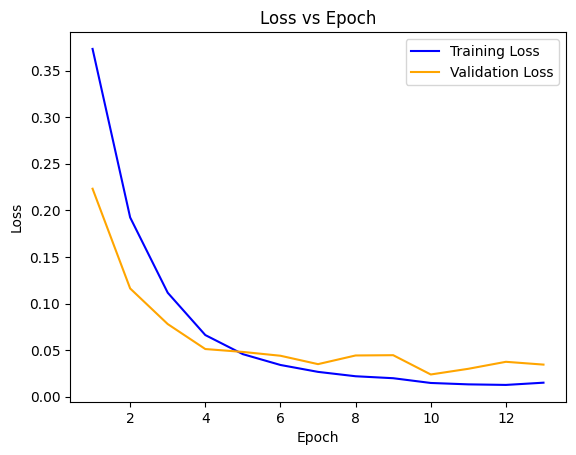

In [33]:
total_epochs = [i+1 for i in range(len(training_loss))]
plt.plot(total_epochs, training_loss, 'blue', label='Training Loss')
plt.plot(total_epochs, validation_loss, 'orange', label='Validation Loss')
plt.title('Loss vs Epoch')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

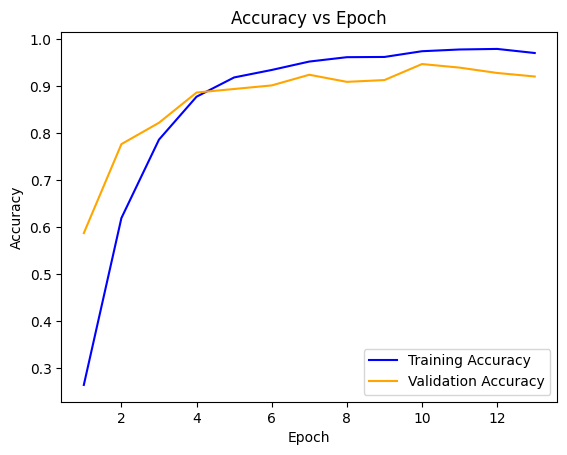

In [34]:
plt.plot(total_epochs, training_accuracy, 'blue', label='Training Accuracy')
plt.plot(total_epochs, validation_accuracy, 'orange', label='Validation Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Test model

### Free memory for testing

In [ ]:
encoder = None
decoder = None
gc.collect()
torch.cuda.empty_cache()

In [38]:
with torch.no_grad():
    encoder = Encoder(14)
    decoder = Decoder(attention_dim=attention_dim, decoder_dim=decoder_dim, num_classes=len(class_map))
    encoder = nn.DataParallel(encoder)
    decoder = nn.DataParallel(decoder)
    encoder.load_state_dict(state_dict_encoder)
    decoder.load_state_dict(state_dict_decoder)
    encoder.eval()
    decoder.eval()
    encoder.to(device)
    decoder.to(device)

    softmax = nn.Softmax()
    test_correct = 0
    total_test = 0
    actual = []
    predicted = []

    for data, label in tqdm(test_data_loader, total=len(test_data_loader)):
        data = data.to(device)
        label = label.to(device)
        num_batches = data.size()[0]
        seq_len = data.size()[1]
        channels = data.size()[2]
        width = data.size()[3]
        data = data.view(-1, channels, width, width)

        encoder_out = encoder(data)
        encoder_out = encoder_out.view(num_batches, seq_len,pixels, pixels, encoder_dim)
        output = decoder(encoder_out)

        preds = torch.argmax(softmax(output), dim=1)
        test_correct += (preds == label).float().sum()
        total_test += num_batches
        actual.append(label.item())
        predicted.append(preds.item())
        
    print(f"Test Accuracy = {round(float(test_correct/total_test), 4)}")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/1620 [00:00<?, ?it/s]/tmp/ipykernel_26/1643512433.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  alpha = self.softmax(attn)
/tmp/ipykernel_26/2896516012.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argu

Test Accuracy = 0.934


### Plot Confusion Matrix

In [39]:
actual_str = []
predicted_str = []
for val in actual:
    actual_str.append(id_to_class[val])
for val in predicted:
    predicted_str.append(id_to_class[val])

In [40]:
cm = confusion_matrix(actual_str, predicted_str, labels=list(id_to_class.values()))

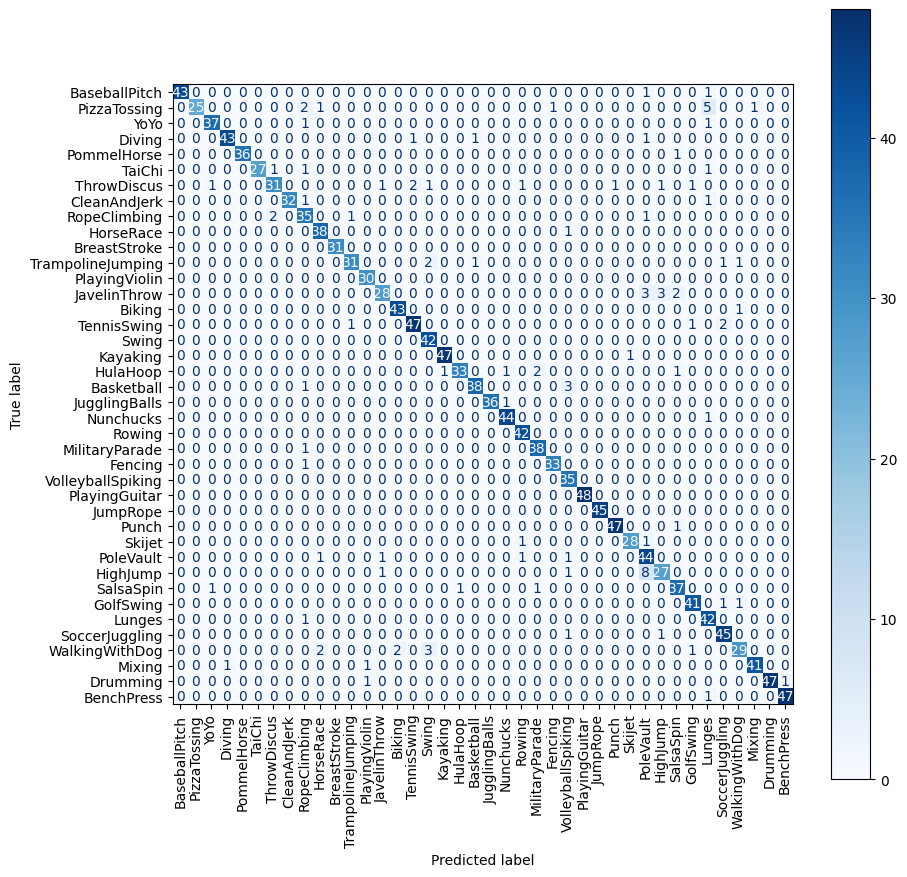

In [41]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(id_to_class.values()))
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.xticks(rotation="vertical")
plt.show()

### Plot Some videos with Predicted Activity

In [42]:
class VideoDataGenerator():
    def __init__(self, df, total_frames_to_train=50):
        self.classes = df["Class"].to_list()
        self.video_names = df["Video"].to_list()
        self.total_frames = df["Total_Frames"].to_list()
        self.total_frames_to_train = total_frames_to_train
    def get(self, index):
        total_frames = self.total_frames[index]
        video_path = os.path.abspath(os.path.join(video_directory_path, self.classes[index], self.video_names[index]))
        video = cv2.VideoCapture(video_path)
        all_images = []
        frames = []
        while True:
            image = video.read()
            if image[0] == False:
                break
            frames.append(image[1])
            image = cv2.resize(image[1], (224, 224))
            np_image = np.array(image).astype('float32')/255
            all_images.append(np_image)
        if total_frames != len(all_images):
            total_frames = len(all_images)
        if len(all_images) < self.total_frames_to_train:
            last_frame = all_images[-1]
            additinal_frames = [last_frame] * (self.total_frames_to_train - len(all_images))
            additional_images = [frames[-1]] * (self.total_frames_to_train - len(all_images))
            all_images.extend(additinal_frames)
            frames.extend(additional_images)
            total_frames = self.total_frames_to_train
        frame_onset = random.randint(0, total_frames - self.total_frames_to_train)
        all_images = all_images[frame_onset:frame_onset+self.total_frames_to_train]
        frames = frames[frame_onset:frame_onset+self.total_frames_to_train]
        tensor = torch.from_numpy(np.array(all_images))
        tensor = torch.transpose(tensor, 1, 3)
        return tensor, torch.tensor(class_map[self.classes[index]]), frames

In [43]:
test_data_generator = VideoDataGenerator(df_test, total_frames_to_train=30)

In [44]:
def get_prediction(index):
    data, label, image_frames = test_data_generator.get(index)
    data = data.unsqueeze(0)
    data = data.to(device)
    label = label.to(device)
    num_batches = data.size()[0]
    seq_len = data.size()[1]
    channels = data.size()[2]
    width = data.size()[3]
    data = data.view(-1, channels, width, width)
    encoder_out = encoder(data)
    encoder_out = encoder_out.view(num_batches, seq_len,pixels, pixels, encoder_dim)
    output = decoder(encoder_out)
    preds = torch.argmax(softmax(output), dim=1)
    return image_frames, id_to_class[preds.item()]

/tmp/ipykernel_26/1643512433.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  alpha = self.softmax(attn)
/tmp/ipykernel_26/2896516012.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention_output = self.softmax(self.out_attention(output_all_sequence).squeeze(2))
/tmp/ipykernel_26/1916893392.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  preds = torch.argmax(softmax(output), dim=1)


BaseballPitch


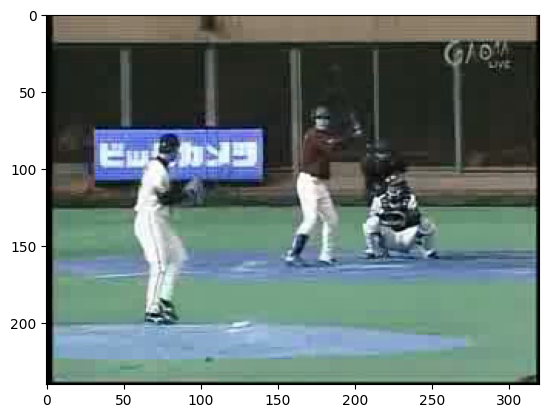

In [45]:
image_frames, prediction = get_prediction(6)
frames = []
fig = plt.figure()
viewer = fig.add_subplot(111)
fig.show()
print(prediction)
for i in range(len(image_frames)):
    viewer.clear() # Clears the previous image
    viewer.imshow(image_frames[i])
    plt.pause(.1)
    fig.canvas.draw()

/tmp/ipykernel_26/1643512433.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  alpha = self.softmax(attn)
/tmp/ipykernel_26/2896516012.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention_output = self.softmax(self.out_attention(output_all_sequence).squeeze(2))
/tmp/ipykernel_26/1916893392.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  preds = torch.argmax(softmax(output), dim=1)


Lunges


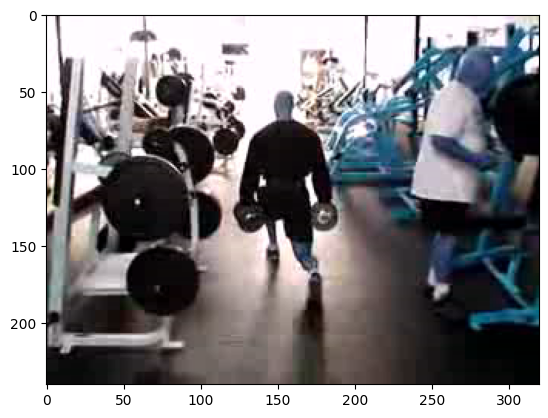

In [46]:
image_frames, prediction = get_prediction(700)
frames = []
fig = plt.figure()
viewer = fig.add_subplot(111)
fig.show()
print(prediction)
for i in range(len(image_frames)):
    viewer.clear() # Clears the previous image
    viewer.imshow(image_frames[i])
    plt.pause(.1)
    fig.canvas.draw()

/tmp/ipykernel_26/1643512433.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  alpha = self.softmax(attn)
/tmp/ipykernel_26/2896516012.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention_output = self.softmax(self.out_attention(output_all_sequence).squeeze(2))
/tmp/ipykernel_26/1916893392.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  preds = torch.argmax(softmax(output), dim=1)


SoccerJuggling


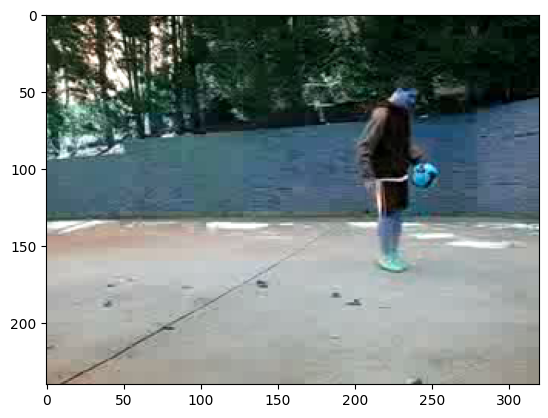

In [47]:
image_frames, prediction = get_prediction(1300)
frames = []
fig = plt.figure()
viewer = fig.add_subplot(111)
fig.show()
print(prediction)
for i in range(len(image_frames)):
    viewer.clear() # Clears the previous image
    viewer.imshow(image_frames[i])
    plt.pause(.1)
    fig.canvas.draw()

/tmp/ipykernel_26/1643512433.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  alpha = self.softmax(attn)
/tmp/ipykernel_26/2896516012.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention_output = self.softmax(self.out_attention(output_all_sequence).squeeze(2))
/tmp/ipykernel_26/1916893392.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  preds = torch.argmax(softmax(output), dim=1)


Basketball


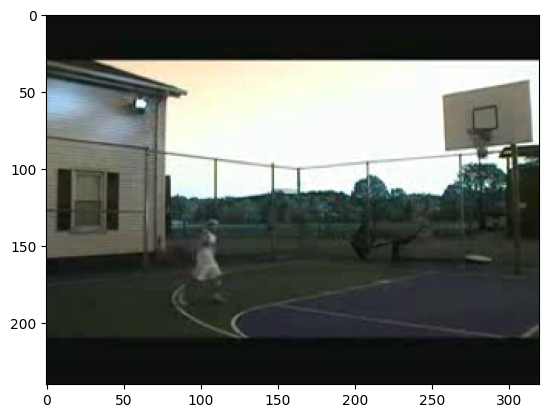

In [48]:
image_frames, prediction = get_prediction(56)
frames = []
fig = plt.figure()
viewer = fig.add_subplot(111)
fig.show()
print(prediction)
for i in range(len(image_frames)):
    viewer.clear() # Clears the previous image
    viewer.imshow(image_frames[i])
    plt.pause(.1)
    fig.canvas.draw()

/tmp/ipykernel_26/1643512433.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  alpha = self.softmax(attn)
/tmp/ipykernel_26/2896516012.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention_output = self.softmax(self.out_attention(output_all_sequence).squeeze(2))
/tmp/ipykernel_26/1916893392.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  preds = torch.argmax(softmax(output), dim=1)


Swing


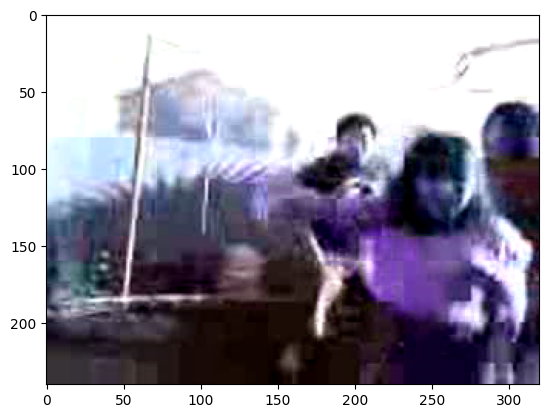

In [49]:
image_frames, prediction = get_prediction(1500)
frames = []
fig = plt.figure()
viewer = fig.add_subplot(111)
fig.show()
print(prediction)
for i in range(len(image_frames)):
    viewer.clear() # Clears the previous image
    viewer.imshow(image_frames[i])
    plt.pause(.1)
    fig.canvas.draw()